# A comparison between generator/gan/gan+pretraining

In [72]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os.path as op
import time

# import tensorflow as tf
from keras.callbacks import TensorBoard, ModelCheckpoint, History, CallbackList, BaseLogger, EarlyStopping
from keras_tqdm import TQDMNotebookCallback
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import cifar10
from skimage import color
from IPython.display import display, HTML
import pandas as pd
import seaborn as sns


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
from fastmri_recon.data.test_generators import CifarGenerator
from fastmri_recon.helpers.adversarial_training import compile_models, adversarial_training_loop
from fastmri_recon.helpers.image_tboard_cback import TensorBoardImage
from fastmri_recon.helpers.keras_utils import wasserstein_loss
from fastmri_recon.models.discriminator import discriminator_model, generator_containing_discriminator_multiple_outputs
from fastmri_recon.models.unet import unet
from fastmri_recon.helpers.evaluate import psnr, ssim, mse, nmse

In [74]:
run_params = {
    'n_layers': 4, 
    'pool': 'max', 
    "layers_n_channels": [16, 32, 64, 128], 
    'layers_n_non_lins': 2,
}

im_size = 32

perceptual_loss = 'mae'
discriminator_lr = 1e-4
d_on_reconstructor_lr = 1e-3
AF = 2
sns.set_style('white')

In [75]:
# model definition

def generator_model():
    model = unet(input_size=(im_size, im_size, 1), **run_params, compile=False)
    model.name = 'Reconstructor'
    return model

In [76]:
def show_images(images, cols = 1, title=None, titles = None, scale = 1, savepath=""):
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure(facecolor="white")
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)) +1 , n + 1)
        plt.imshow(image,  interpolation='nearest')
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images * scale)
    if savepath !='':
        plt.savefig(savepath)
    plt.show()

In [77]:
# Data loading

(x_train, _), (x_test, _) = cifar10.load_data()

x_train = color.rgb2gray(x_train)
x_test = color.rgb2gray(x_test)

val_gen = CifarGenerator(AF, im_size, x_test, max_size=10000).flow_z_filled_images()
train_gen = CifarGenerator(AF, im_size, x_train, max_size=50000).flow_z_filled_images()

## 1. Generator training

In [78]:
gen = generator_model()
d = discriminator_model(im_size)
d_on_g = generator_containing_discriminator_multiple_outputs(gen, d, im_size=im_size)

compile_models(
    d, 
    gen, 
    d_on_g, 
    d_lr=discriminator_lr, 
    d_on_g_lr=d_on_reconstructor_lr, 
    perceptual_loss=perceptual_loss, 
    perceptual_weight=1.0,
)

In [79]:
run_id = f'unet_gan_af{AF}_{int(time.time())}'
chkpt_path = f'../checkpoints/{run_id}' + '-{epoch:02d}.hdf5'
print(run_id)

unet_gan_af2_1576074608


In [80]:
# callbacks definition

log_dir = op.join('logs/training', run_id)

tqdm_cb = TQDMNotebookCallback(metric_format="{name}: {value:e}")

tboard_cback = TensorBoard(
    log_dir=log_dir, 
    write_graph=True, 
    update_freq=50,
)

chkpt_cback = ModelCheckpoint(chkpt_path, period=100)

selected_slice = 0

data = next(val_gen)

tboard_image_cback = TensorBoardImage(
    log_dir=log_dir + '/images',
    image=data[1][selected_slice:selected_slice+1],
    # NOTE: for cross-domain slice has to be on kspace and mask
    model_input=data[0][selected_slice:selected_slice+1],
)

log_dir_pre = op.join('logs/pretraining', run_id)

tboard_cback_pre = TensorBoard(
    log_dir=log_dir_pre, 
    write_graph=True, 
    update_freq=50)

tqdm_cb_pre = TQDMNotebookCallback(outer_description = "Pre-training", metric_format="{name}: {value:e}")

tboard_image_cback_pre = TensorBoardImage(
    log_dir=log_dir + '/images',
    image=data[1][selected_slice:selected_slice+1],
    # NOTE: for cross-domain slice has to be on kspace and mask
    model_input=data[0][selected_slice:selected_slice+1],
)

/Users/WorkAccount/miniconda3/envs/gan/lib/python3.7/site-packages/fastmri_recon-0.0.1-py3.7.egg/fastmri_recon/data/test_generators.py:77: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/WorkAccount/miniconda3/envs/gan/lib/python3.7/site-packages/fastmri_recon-0.0.1-py3.7.egg/fastmri_recon/helpers/reconstruction.py:40: ComplexWarning: Casting complex values to real discards the imaginary part


In [81]:
%%time
# training
hist = adversarial_training_loop(
    gen, 
    d, 
    d_on_g, 
    train_gen, 
    n_epochs=0, 
    n_batches=20, 
    n_critic_updates=5,
    callbacks=[tqdm_cb, tboard_cback, tboard_image_cback, chkpt_cback],
    include_d_metrics=True,
    gen_pre_training_steps=50,
    pre_training_callbacks=[tqdm_cb_pre, tboard_cback_pre, tboard_image_cback_pre, chkpt_cback]
)



CPU times: user 2min 10s, sys: 1min 10s, total: 3min 20s
Wall time: 4min 41s


In [82]:
ev_generator = gen.evaluate_generator(val_gen, steps=200, callbacks=None, verbose=1)
print('test loss, psnr,ssim:', ev_generator)


200/200 [==============================] - 5s 24ms/step
test loss, psnr,ssim: [0.15338969230651855, 14.506546974182129, 0.40931496024131775, 0.028809843584895134]


In [83]:
# reset the validation data generator
val_gen = CifarGenerator(AF, im_size, x_test, max_size=10000).flow_z_filled_images()

In [86]:
im_alias, im_true = next(val_gen)
im_pred = gen.predict(im_alias)

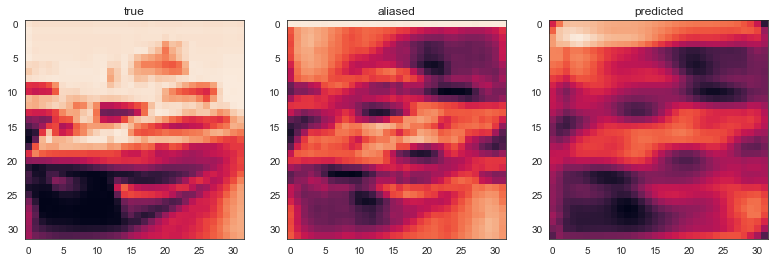

PSNR aliased image:  2.8734487995279796 
PSNR predicted image: 11.007416259579106

MSE aliased image:  0.4557641243694272 
MSE predicted image: 0.07003955700575253

NMSE aliased image:  0.9934861254489645 
NMSE predicted image: 0.1526739916488141


In [87]:
show_images([np.squeeze(im_true), np.squeeze(im_alias),np.squeeze(im_pred)],
            titles=["true", "aliased", "predicted"])
print("PSNR aliased image: ", psnr(im_true, im_alias), "\nPSNR predicted image:", psnr(im_true, im_pred))
# print("ssim aliased image: ", ssim(im_true, im_alias), "\nssim predicted image:", ssim(im_true, im_pred))
print("\nMSE aliased image: ", mse(im_true, im_alias), "\nMSE predicted image:", mse(im_true, im_pred))
print("\nNMSE aliased image: ", nmse(im_true, im_alias), "\nNMSE predicted image:", nmse(im_true, im_pred))

## 2. Gan training


In [88]:
gan = generator_model()
d = discriminator_model(im_size)
d_on_g = generator_containing_discriminator_multiple_outputs(gan, d, im_size=im_size)

compile_models(
    d, 
    gan, 
    d_on_g, 
    d_lr=discriminator_lr, 
    d_on_g_lr=d_on_reconstructor_lr, 
    perceptual_loss=perceptual_loss, 
    perceptual_weight=1.0,
)

In [89]:
run_id = f'unet_gan_af{AF}_{int(time.time())}'
chkpt_path = f'checkpoints/{run_id}' + '-{epoch:02d}.hdf5'
print(run_id)

unet_gan_af2_1576075079


In [90]:
# callbacks definition

log_dir = op.join('logs/training', run_id)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=0,
                          verbose=0, mode='auto')

tqdm_cb = TQDMNotebookCallback(metric_format="{name}: {value:e}")

tboard_cback = TensorBoard(
    log_dir=log_dir, 
    write_graph=True, 
    update_freq=50,
)

chkpt_cback = ModelCheckpoint(chkpt_path, period=100)

selected_slice = 0

data = next(val_gen)

tboard_image_cback = TensorBoardImage(
    log_dir=log_dir + '/images',
    image=data[1][selected_slice:selected_slice+1],
    # NOTE: for cross-domain slice has to be on kspace and mask
    model_input=data[0][selected_slice:selected_slice+1],
)

log_dir_pre = op.join('logs/pretraining', run_id)

tboard_cback_pre = TensorBoard(
    log_dir=log_dir_pre, 
    write_graph=True, 
    update_freq=50)

tqdm_cb_pre = TQDMNotebookCallback(outer_description = "Pre-training", metric_format="{name}: {value:e}")

tboard_image_cback_pre = TensorBoardImage(
    log_dir=log_dir + '/images',
    image=data[1][selected_slice:selected_slice+1],
    # NOTE: for cross-domain slice has to be on kspace and mask
    model_input=data[0][selected_slice:selected_slice+1],
)

In [91]:
%%time
# training
hist = adversarial_training_loop(
    gan, 
    d, 
    d_on_g, 
    train_gen, 
    val_gen,
    validation_steps=1,
    n_epochs=50, 
    n_batches=5, 
    n_critic_updates=5,
    callbacks=[tqdm_cb, tboard_cback, tboard_image_cback, earlystop],
    include_d_metrics=True,
    gen_pre_training_steps=0,
    pre_training_callbacks=[tqdm_cb_pre, tboard_cback_pre, tboard_image_cback_pre]
)

/Users/WorkAccount/miniconda3/envs/gan/lib/python3.7/site-packages/fastmri_recon-0.0.1-py3.7.egg/fastmri_recon/data/test_generators.py:77: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/WorkAccount/miniconda3/envs/gan/lib/python3.7/site-packages/fastmri_recon-0.0.1-py3.7.egg/fastmri_recon/helpers/reconstruction.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/WorkAccount/miniconda3/envs/gan/lib/python3.7/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: val_Reconstructor/loss,val_Reconstructor/keras_psnr,val_Reconstructor/keras_ssim,val_Reconstructor/mse,loss,Reconstructor/loss,Discriminator/loss,Reconstructor/keras_psnr,Reconstructor/keras_ssim,Reconstructor/mse,d_training/loss_fake,d_training/mean_output_fake,d_training/discriminator_accuracy_fake,d_training/loss_real,d_training/mean_output_real,d_train


CPU times: user 5min 24s, sys: 1min 38s, total: 7min 3s
Wall time: 5min 30s


In [92]:
ev_gan = gan.evaluate_generator(val_gen, steps=200, callbacks=None, verbose=1)
print('test loss, psnr,ssim:', ev_gan)

200/200 [==============================] - ETA:  - 4s 21ms/step
test loss, psnr,ssim: [0.2126721888780594, 10.705397605895996, 0.1666942834854126, 0.06946474313735962]


In [93]:
# reset the validation data generator
val_gen = CifarGenerator(AF, im_size, x_test, max_size=10000).flow_z_filled_images()

In [94]:
im_alias, im_true = next(val_gen)
im_pred = gan.predict(im_alias)

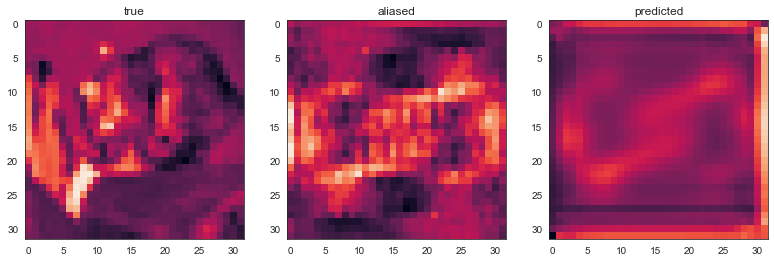

PSNR aliased image:  5.64608000182682 
PSNR predicted image: 14.103720551840466

MSE aliased image:  0.2067196548041435 
MSE predicted image: 0.02948612593666389

NMSE aliased image:  0.9927840083429269 
NMSE predicted image: 0.14160895501514137


/Users/WorkAccount/miniconda3/envs/gan/lib/python3.7/site-packages/fastmri_recon-0.0.1-py3.7.egg/fastmri_recon/helpers/evaluate.py:25: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.


In [95]:
show_images([np.squeeze(im_true), np.squeeze(im_alias),np.squeeze(im_pred)],
            titles=["true", "aliased", "predicted"])
print("PSNR aliased image: ", psnr(im_true, im_alias), "\nPSNR predicted image:", psnr(im_true, im_pred))
# print("ssim aliased image: ", ssim(im_true, im_alias), "\nssim predicted image:", ssim(im_true, im_pred))
print("\nMSE aliased image: ", mse(im_true, im_alias), "\nMSE predicted image:", mse(im_true, im_pred))
print("\nNMSE aliased image: ", nmse(im_true, im_alias), "\nNMSE predicted image:", nmse(im_true, im_pred))

## 3. GAN training with generator pretraining

In [96]:
pregan = generator_model()
d = discriminator_model(im_size)
d_on_g = generator_containing_discriminator_multiple_outputs(pregan, d, im_size=im_size)

compile_models(
    d, 
    pregan, 
    d_on_g, 
    d_lr=discriminator_lr, 
    d_on_g_lr=d_on_reconstructor_lr, 
    perceptual_loss=perceptual_loss, 
    perceptual_weight=1.0,
)

In [97]:
run_id = f'unet_gan_af{AF}_{int(time.time())}'
chkpt_path = f'checkpoints/{run_id}' + '-{epoch:02d}.hdf5'
print(run_id)

unet_gan_af2_1576075436


In [98]:
# callbacks definition

log_dir = op.join('logs/training', run_id)

earlystop = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=0,
                              verbose=0, mode='auto')

tqdm_cb = TQDMNotebookCallback(metric_format="{name}: {value:e}")

tboard_cback = TensorBoard(
    log_dir=log_dir, 
    write_graph=True, 
    update_freq=50,
)

chkpt_cback = ModelCheckpoint(chkpt_path, period=100)

selected_slice = 0

data = next(val_gen)

tboard_image_cback = TensorBoardImage(
    log_dir=log_dir + '/images',
    image=data[1][selected_slice:selected_slice+1],
    # NOTE: for cross-domain slice has to be on kspace and mask
    model_input=data[0][selected_slice:selected_slice+1],
)

log_dir_pre = op.join('logs/pretraining', run_id)

tboard_cback_pre = TensorBoard(
    log_dir=log_dir_pre, 
    write_graph=True, 
    update_freq=50)

tqdm_cb_pre = TQDMNotebookCallback(outer_description = "Pre-training", metric_format="{name}: {value:e}")

tboard_image_cback_pre = TensorBoardImage(
    log_dir=log_dir + '/images',
    image=data[1][selected_slice:selected_slice+1],
    # NOTE: for cross-domain slice has to be on kspace and mask
    model_input=data[0][selected_slice:selected_slice+1],
)

In [99]:
%%time
# training
hist = adversarial_training_loop(
    pregan, 
    d, 
    d_on_g, 
    train_gen, 
    n_epochs=50, 
    n_batches=1, 
    n_critic_updates=5,
    callbacks=[tqdm_cb, tboard_cback, tboard_image_cback],
    include_d_metrics=True,
    gen_pre_training_steps=5,
    pre_training_callbacks=[tqdm_cb_pre, tboard_cback_pre, tboard_image_cback_pre]
)

/Users/WorkAccount/miniconda3/envs/gan/lib/python3.7/site-packages/fastmri_recon-0.0.1-py3.7.egg/fastmri_recon/data/test_generators.py:77: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/WorkAccount/miniconda3/envs/gan/lib/python3.7/site-packages/fastmri_recon-0.0.1-py3.7.egg/fastmri_recon/helpers/reconstruction.py:40: ComplexWarning: Casting complex values to real discards the imaginary part



CPU times: user 2min 40s, sys: 34.2 s, total: 3min 14s
Wall time: 3min 10s


In [100]:
ev_pregan = pregan.evaluate_generator(val_gen, steps=200, callbacks=None, verbose=1)
print('test loss, psnr,ssim:', ev_pregan)

200/200 [==============================] - 6s 29ms/step
test loss, psnr,ssim: [0.27257174253463745, 10.305988311767578, 0.11692772060632706, 0.07881344109773636]


In [101]:
# reset the validation data generator
val_gen = CifarGenerator(AF, im_size, x_test, max_size=10000).flow_z_filled_images()

In [102]:
im_alias, im_true = next(val_gen)
im_pred = pregan.predict(im_alias)

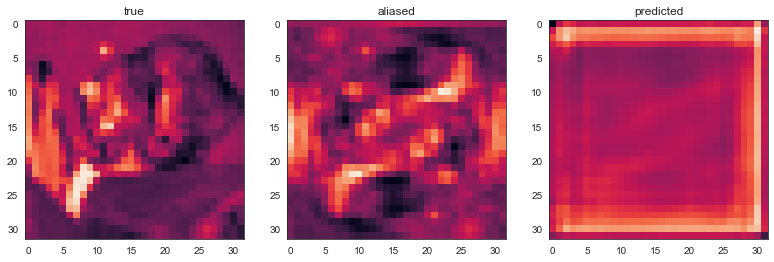

PSNR aliased image:  5.6462818072341285 
PSNR predicted image: 13.886662941256379

MSE aliased image:  0.20671004929989562 
MSE predicted image: 0.030997272208213987

NMSE aliased image:  0.9927378773109338 
NMSE predicted image: 0.14886632903738128


/Users/WorkAccount/miniconda3/envs/gan/lib/python3.7/site-packages/fastmri_recon-0.0.1-py3.7.egg/fastmri_recon/helpers/evaluate.py:25: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.


In [103]:
show_images([np.squeeze(im_true), np.squeeze(im_alias),np.squeeze(im_pred)],
            titles=["true", "aliased", "predicted"])
print("PSNR aliased image: ", psnr(im_true, im_alias), "\nPSNR predicted image:", psnr(im_true, im_pred))
# print("ssim aliased image: ", ssim(im_true, im_alias), "\nssim predicted image:", ssim(im_true, im_pred))
print("\nMSE aliased image: ", mse(im_true, im_alias), "\nMSE predicted image:", mse(im_true, im_pred))
print("\nNMSE aliased image: ", nmse(im_true, im_alias), "\nNMSE predicted image:", nmse(im_true, im_pred))

# Comparison

In [104]:
styles = [dict(props=[("font-size", "130%"),("text-align", "center")])]
df = pd.DataFrame([ev_generator, ev_gan, ev_pregan], columns = ['loss' , 'psnr', 'ssim', 'mse']) 
df.insert(0, '', ["generator", "gan", "pregan"])
html = (df.style.set_table_styles(styles))
# print("Evaluation Table:")
display(html)

,,loss,psnr,ssim,mse
0,generator,0.15339,14.5065,0.409315,0.0288098
1,gan,0.212672,10.7054,0.166694,0.0694647
2,pregan,0.272572,10.306,0.116928,0.0788134


In [105]:
val_gen = CifarGenerator(AF, im_size, x_test, max_size=10000).flow_z_filled_images()

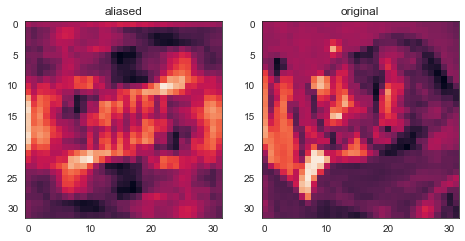

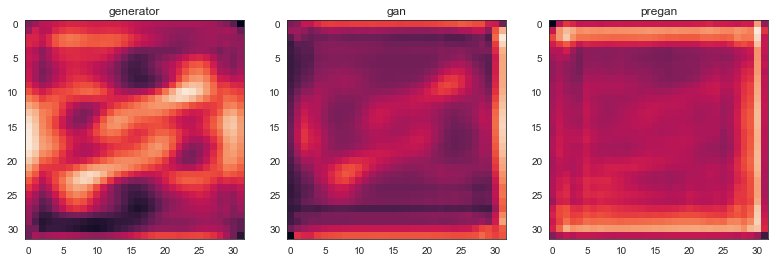

In [106]:
im_alias, im_true = next(val_gen)

im1 = gen.predict(im_alias)
im2 = gan.predict(im_alias)
im3 = pregan.predict(im_alias)
show_images([np.squeeze(im_alias), np.squeeze(im_true)],
            titles=["aliased", "original"])
show_images([np.squeeze(im1), np.squeeze(im2), np.squeeze(im3)], titles=["generator", "gan", "pregan"])

In [107]:
import tensorboard
import os
%load_ext tensorboard
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)
%tensorboard --logdir {logs_base_dir}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6009 (pid 66036), started 3:42:34 ago. (Use '!kill 66036' to kill it.)